In [1]:
from jax import jit
from main import *
from functools import partial
import time as tm
# Bi modules
bi = bi(platform='cpu')
print(bi.dist.normal(0,1, sample = True, shape=(1,), seed = 1))
bi.net.mat_to_edgl(jnp.array([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 15, 16]]))
print(bi.gaussian_process)
print(bi.random_centered)

jax.local_device_count 32
[-1.1842843]
<function Mgaussian.gaussian_process at 0x7f183e3d5ab0>
<PjitFunction of <function factors.random_centered at 0x7f183e3db640>>


# Networks Models

## Rethinking

In [7]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.lkj(2, 4, name = "Rho_gr")
    sigma_gr = dist.exponential( 1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = dist.multivariatenormal(0, cov, name = "gr", shape = [N_households])

    # dyad effects
    z = dist.normal(0, 1, name = 'z', shape = [2, N])
    L_Rho_d = dist.lkjcholesky(2, 8, name = "L_Rho_d")
    sigma_d = dist.exponential(1, name = "sigma_d", shape = [1])
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[:, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------
m.run(model) 
res = az.from_numpyro(m.sampler)
res

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:03<00:00, 260.89it/s, 63 steps of size 9.02e-02. acc. prob=0.89]


BI took: 5.9322 seconds


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Trying bi functions

In [42]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    ## SR ---------------------------------------
    d, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(N_households, cholesky_density= 4)

    # dyad effects ---------------------------------------
    gr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(N, cholesky_density= 8 )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + d[hidA, 0] + d[hidB, 1] + gr[:, 0])
    lambdaBA = jnp.exp(a + d[hidB, 0] + d[hidA, 1] + gr[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
res2 = az.from_numpyro(m.sampler)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:06<00:00, 156.74it/s, 255 steps of size 2.22e-02. acc. prob=0.93]


BI took: 6.6370 seconds


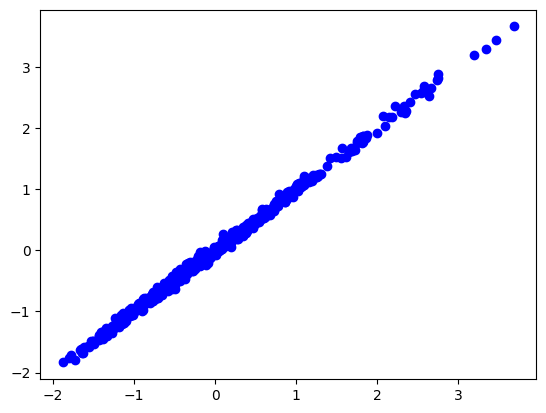

In [43]:
plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,0],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,0], marker='o', linestyle='None', color='b', label='Posteriors')

plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,1],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,1], marker='o', linestyle='None', color='b', label='Posteriors')

## STRAND

### Sender receiver model

#### STRAND simulation

In [1]:
%load_ext rpy2.ipython

In [7]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Mass = rbern(N_id, 0.4)

B_1 = matrix(-10,nrow=1,ncol=1)
B=list(B_1)
groups_1 = rep("Any",N_id) 
groups = data.frame(Intercept=as.numeric(factor(groups_1)))
groups_f = data.frame(Intercept=factor(groups_1))
#################################################### Simulate SBM + SRM network
sr_effects_1 = c(-1.9, 1.3)
G = simulate_srm_network(N_id = N_id, 
                         B = B, 
                         V=1,
                         groups=groups,                  
                         sr_mu = c(0,0),  
                         sr_sigma = c(2.2, 1.7) , 
                         sr_rho = 0.55,
                         mode="poisson",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = NULL,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = NULL
                         )        

################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "poisson")

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ 1,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr only.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 109.7 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "1.931"  "1.579"   "2.383"  
[2,] "focal effects coeffs (out-degree), Mass" "-1.467" "-2.369"  "-0.769" 
     Mean     SD     
[1,] "1.96"   "0.254"
[2,] "-1.456" "0.501"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.345" "1.101"   "1.58"   
[2,] "target effects coeffs (in-degree), Mass" "1.45"  "0.797"   "2.02"   
     Mean    SD     
[1,] "1.359" "0.166"
[2,] "1.425" "0.386"

$`Dyadic effects`
     Variable            Median  HPDI:0.05 HPDI:0.95 Mean    SD     
[1,] "dya

Loading required package: cmdstanr
This is cmdstanr version 0.8.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.35.0
- CmdStan version: 2.35.0
Loading required package: posterior
This is posterior version 1.6.0

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpw5c4ik/model-91337dd

#### Send simulation to python

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(STRAND)
load('STRAND sim sr only.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "1.931"  "1.579"   "2.383"  
[2,] "focal effects coeffs (out-degree), Mass" "-1.467" "-2.369"  "-0.769" 
     Mean     SD     
[1,] "1.96"   "0.254"
[2,] "-1.456" "0.501"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.345" "1.101"   "1.58"   
[2,] "target effects coeffs (in-degree), Mass" "1.45"  "0.797"   "2.02"   
     Mean    SD     
[1,] "1.359" "0.166"
[2,] "1.425" "0.386"

$`Dyadic effects`
     Variable            Median  HPDI:0.05 HPDI:0.95 Mean    SD     
[1,] "dyadic effects sd" "0.977" "0.842"   "1.062"   "0.975" "0.066"

$`Other estimates`
     Variable                                            Median   HPDI:0.05
[1,] "focal-target effects rho (generalized recipocity)" "0.531"  "0.325"  
[2,] "dyadic effects rho (dyad

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


#### Model

In [3]:
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
id = r.randint(1, data['N_id'][0]-1)


ids = jnp.arange(0,data['N_id'][0])
idx = bi.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))
@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model(idx, result_outcomes,focal_individual_predictors, target_individual_predictors):
    N_id = ids.shape[0]

    ## Block ---------------------------------------
    B = bi.dist.normal(logit(0.1/jnp.sqrt(N_id)), 2.5, shape=(1,), name = 'block')

    #SR ---------------------------------------
    sr =  bi.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    ### Dyadic--------------------------------------  
    dr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(idx.shape[0], cholesky_density = 2)# shape = n dyads
 
    ## SR ---------------------------------------                                                      
    lk('Y', Poisson(jnp.exp(B + sr + dr), is_sparse = False), obs=result_outcomes)  

    ## NBDA -----------------------------     

m.data_on_model = dict(
    idx = idx,
    result_outcomes = bi.net.mat_to_edgl(data['outcomes']), 
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors'],
)

m.run(model) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'block[0]',]]
# focal_effects = -1.9,
# target_effects =  1.3
# block =  -4

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:16<00:00, 62.06it/s, 127 steps of size 2.94e-02. acc. prob=0.93] 


,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],-1.59,0.55,-2.42,-0.71
target_effects[0],1.36,0.37,0.69,1.89
block[0],-3.81,0.51,-4.53,-2.98


In [4]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr only.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)


                               res.summary.Variable res.summary.Median
1                                  focal effects sd              1.931
2           focal effects coeffs (out-degree), Mass             -1.467
3                                 target effects sd              1.345
4           target effects coeffs (in-degree), Mass               1.45
5                                 dyadic effects sd              0.977
6 focal-target effects rho (generalized recipocity)              0.531
7            dyadic effects rho (dyadic recipocity)              0.783
8                             intercept, any to any             -3.933


### Sender receiver & dyadic effects model

#### Method accuracy demonstration.

In [2]:
%load_ext rpy2.ipython

In [5]:
%%R 
library(STRAND)
dr_raw = matrix(0, ncol = 3, nrow = 3)
dr_raw[1,] = c(0, 0.6, 0.66)
dr_raw[2,] = c(0.1, 0, 0.9)
dr_raw[3,] = c(-0.5, 0.24, 0)
tl = lower.tri(dr_raw, diag = FALSE)
tu = upper.tri(dr_raw, diag = FALSE)
dr2 = cbind(dr_raw[tl], dr_raw[tu])
d.sigma = c(0.2,0.2)

Rho = matrix(1, ncol = 2, nrow = 2)
rho = 0.73
Rho[1,2] = rho
Rho[2,1] = rho
L = chol(Rho)

R = NULL
for( a in 1:nrow(dr2)){
  R[[a]] = (L %*% dr2[a,]) * d.sigma
}
R


[[1]]
           [,1]
[1,] 0.10760000
[2,] 0.08201366

[[2]]
            [,1]
[1,] -0.00364000
[2,]  0.09021502

[[3]]
          [,1]
[1,] 0.1794000
[2,] 0.1230205



In [6]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
L = jnp.array(ro.globalenv['L']).reshape(2,2)
dr2 = jnp.array(ro.globalenv['dr2']).reshape(3,2).T
d_sigma = jnp.array(ro.globalenv['d.sigma'])
(L @ dr2).T * d_sigma

Array([[ 0.10760001,  0.08201366],
       [-0.00363999,  0.09021502],
       [ 0.17940001,  0.12302049]], dtype=float32)

Code used in function is:

In [7]:
dr_raw =  dist.normal(0, 1, shape=(2, 3), name = 'dr_raw', sample = True)
dr_sigma = dist.exponential(1, shape=(1,), name = 'dr_sigma', sample = True )
dr_L = dist.lkjcholesky(2, 2, name = 'dr_L', sample = True)
rf = ((dr_L @ dr_raw).T * jnp.repeat(dr_sigma, 2))
rf

Array([[ 0.10182459,  0.6520411 ],
       [-0.695662  ,  0.24218999],
       [ 0.35203034, -0.11920679]], dtype=float32)

#### Simulated data

In [11]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship
#dyadic_preds[,,2] = Dominant
#dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0  
dr_sigma = 1.5
dr_rho= 0.6

#################################################### Simulate SBM + SRM network
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         #B = B, 
                         #V=3,
                         #groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         mode="poisson",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1                         
                         )        
################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "poisson", dyadic_covariates=list(Kinship=Kinship))

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr dyad.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 458.9 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "1.971" "1.729"   "2.15"   
[2,] "focal effects coeffs (out-degree), Mass" "2.5"   "1.885"   "3.007"  
     Mean   SD     
[1,] "1.96" "0.144"
[2,] "2.49" "0.392"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.901" "1.525"   "2.153"  
[2,] "target effects coeffs (in-degree), Mass" "1.127" "0.813"   "1.563"  
     Mean    SD     
[1,] "1.876" "0.203"
[2,] "1.176" "0.23" 

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic 

Loading required package: cmdstanr
This is cmdstanr version 0.8.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.35.0
- CmdStan version: 2.35.0
Loading required package: posterior
This is posterior version 1.6.0

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpw5c4ik/model-91337dd

#### Send simulation to python

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dyad.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "1.971" "1.729"   "2.15"   
[2,] "focal effects coeffs (out-degree), Mass" "2.5"   "1.885"   "3.007"  
     Mean   SD     
[1,] "1.96" "0.144"
[2,] "2.49" "0.392"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.901" "1.525"   "2.153"  
[2,] "target effects coeffs (in-degree), Mass" "1.127" "0.813"   "1.563"  
     Mean    SD     
[1,] "1.876" "0.203"
[2,] "1.176" "0.23" 

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "1.492" "1.446"   "1.522"   "1.49" 
[2,] "dyadic effects coeffs, Kinship" "1.169" "0.909"   "1.39"    "1.169"
     SD     
[1,] "0.023"
[2,] "0.151"

$`Other estimates`
     Variable                                            Median   HP

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


#### Model

In [6]:
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'].reshape(data['N_id'][0],data['N_id'][0]).T
exposure = data['exposure'].reshape(data['N_id'][0],data['N_id'][0]).T

def model(ids, result_outcomes, dyadic_predictors, focal_individual_predictors, target_individual_predictors):

    # Block ---------------------------------------
    #B = bi.dist.normal(bi.logit(0.1/jnp.sqrt(ids.shape[0])), 2.5, shape=(1,), name = 'block')
    
    ## SR shape =  N individuals---------------------------------------
    sr =  bi.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = bi.net.dyadic_effect(dyadic_predictors)

    lk('Y', Poisson(jnp.exp(sr + dr), sparse=True), obs=result_outcomes)

m.data_on_model = dict(
    ids = jnp.arange(0,data['N_id'][0]),
    result_outcomes = bi.net.mat_to_edgl(data['outcomes']), 
    dyadic_predictors = bi.net.prepare_dyadic_effect(kinship), # Can be a jax array of multiple dimensions
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors']
)

m.run(model) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]',  'sr_sigma[0]', 'sr_sigma[1]']]
#summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]', 'block[0]', 'sr_sigma[0]', 'sr_sigma[1]']]
# focal_effects = 1.9,
# target_effects =  1.3
# dr_effects = 1.2
# block =  -4

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [01:08<00:00, 14.69it/s, 1023 steps of size 1.71e-03. acc. prob=0.92]


,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],1.83,0.16,1.55,2.06
target_effects[0],0.56,0.22,0.18,0.84
dyad_effects[0],1.23,0.31,0.71,1.73
sr_sigma[0],2.00,0.12,1.79,2.17
sr_sigma[1],1.75,0.17,1.48,1.98


In [5]:
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]', 'block[0]', 'sr_sigma[0]', 'sr_sigma[1]']]

,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],1.34,0.27,0.96,1.74
target_effects[0],0.64,0.20,0.39,1.00
dyad_effects[0],0.76,0.15,0.54,1.01
block[0],0.18,0.26,-0.22,0.55
sr_sigma[0],1.84,0.11,1.67,2.01
sr_sigma[1],1.68,0.07,1.60,1.82


In [4]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dyad.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)

                               res.summary.Variable res.summary.Median
1                                  focal effects sd              1.971
2           focal effects coeffs (out-degree), Mass                2.5
3                                 target effects sd              1.901
4           target effects coeffs (in-degree), Mass              1.127
5                                 dyadic effects sd              1.492
6                    dyadic effects coeffs, Kinship              1.169
7 focal-target effects rho (generalized recipocity)              0.674
8            dyadic effects rho (dyadic recipocity)              0.623
9                             intercept, any to any             -0.641


### Sender receiver,  dyadic effects & block model
#### Simulation

In [6]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
# Make data
set.seed(1)
library(base)
N_id = 10
V = 3
groups_1 = rep("Any",N_id)                                                                                  # Block Variable 1, Intercept
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=c(0.5, 0.25, 0.25) )           # Block Variable 2, Color
groups_3 = sample( c("Strangeness", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )                 # Block Variable 3, Flavor 

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Color=as.numeric(factor(groups_2)), Flavor=as.numeric(factor(groups_3)))

# Block parameter structure
B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(base::rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(base::rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B = list(B_1, B_2, B_3)

# Build offset matrix
block_offsets = matrix(NA, N_id, N_id)

# Loop over upper triangle and create ties from i to j, and j to i
for ( i in 1:(N_id-1) ){
    for ( j in (i+1):N_id){

 # Loop over block variables
   B_i_j = B_j_i = c()
  for(v in 1:V){
    B_i_j[v] =  B[[v]][groups[i,v] , groups[j,v] ]
    B_j_i[v] =  B[[v]][groups[j,v] , groups[i,v] ]
  }

 block_offsets[i,j] =  sum(B_i_j)
 block_offsets[j,i] =  sum(B_j_i)

 }}

# Now reshape into N_dydads X 2 matrix
melted = cbind(block_offsets[lower.tri(block_offsets,diag=FALSE)],
               block_offsets[upper.tri(block_offsets,diag=FALSE)])

block_offsets
melted

# quick check is the same both column 1 and column 2 becuase ind_1 and ind_2 are in the same block for both color and flavor
melted[1,]
groups[1:2,]


In [3]:
%%R 
#####################################
#
#   Binomial Analyses - Simulated data  
#
########################################

# Clear working space
rm(list = ls())
set.seed(1)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)


# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.6
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2, 1.7, -2.2)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))

#################################################### Simulate SBM + SRM network
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=3,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         mode="binomial",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1
                         )        

################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  block_covariates=groups_f, individual_covariates=data.frame(Mass=Mass), 
                           dyadic_covariates=list(Kinship=Kinship, Dominant=Dominant),  outcome_mode = "binomial", exposure=list(G$samps))

# Model the data with STRAND
fit =  fit_block_plus_social_relations_model(data=model_dat,
                            block_regression = ~ Merica + Quantum,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1, refresh = 500,
                                                          iter_warmup = 500, iter_sampling = 500,
                                                          max_treedepth = NULL, adapt_delta = .9)
)

# Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr dr block.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 195.6 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.608" "2.215"   "3.084"  
[2,] "focal effects coeffs (out-degree), Mass" "1.005" "0.041"   "2"      
     Mean    SD     
[1,] "2.643" "0.28" 
[2,] "1.017" "0.606"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.854" "1.544"   "2.226"  
[2,] "target effects coeffs (in-degree), Mass" "0.876" "0.049"   "1.648"  
     Mean    SD     
[1,] "1.884" "0.222"
[2,] "0.881" "0.483"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyad

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpVGXQWk/model-cc05a275f9d.stan', line 132, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpVGXQWk/model-cc05a275f9d.stan', line 132, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the s

#### Send simulation to python

In [5]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dr block.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.608" "2.215"   "3.084"  
[2,] "focal effects coeffs (out-degree), Mass" "1.005" "0.041"   "2"      
     Mean    SD     
[1,] "2.643" "0.28" 
[2,] "1.017" "0.606"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.854" "1.544"   "2.226"  
[2,] "target effects coeffs (in-degree), Mass" "0.876" "0.049"   "1.648"  
     Mean    SD     
[1,] "1.884" "0.222"
[2,] "0.881" "0.483"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "1.528" "1.429"   "1.626"   "1.529"
[2,] "dyadic effects coeffs, Kinship" "0.781" "0.075"   "1.523"   "0.781"
     SD     
[1,] "0.062"
[2,] "0.448"

$`Other estimates`
      Variable                                            Median 

#### Model

In [10]:
# Building model and sampling it ------------------
m = bi(platform='cpu')

from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'][0,:,:].reshape(data['N_id'][0],data['N_id'][0]).T
Any = data['block_predictors'][0,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Merica  = data['block_predictors'][1,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Quantum  = data['block_predictors'][2,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
ids = jnp.arange(0,data['N_id'][0])
idx = bi.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))

@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model3(idx, result_outcomes, dyadic_predictors, focal_individual_predictors, target_individual_predictors, Any, Merica, Quantum):
    N_id = ids.shape[0]

    # Block ---------------------------------------
    B_any, b_any, b_ij_any, b_ii_any = bi.net.block_model(Any,1, name_b_ij = 'b_ij_Any', name_b_ii = 'b_ii_Any' )
    B_Merica, b_Merica, b_ij_Merica, b_ii_Merica = bi.net.block_model(Merica,  3, name_b_ij = 'b_ij_Merica', name_b_ii = 'b_ii_Merica' )
    B_Quantum, b_Quantum, b_ij_Quantum, b_ii_Quantum = bi.net.block_model(Quantum, 2, name_b_ij = 'b_ij_Quantum', name_b_ii = 'b_ii_Quantum' )

    ## SR shape =  N individuals---------------------------------------
    sr =  bi.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = bi.net.dyadic_effect(dyadic_predictors)

    lk('Y', Poisson(jnp.exp(B_any + B_Merica + B_Quantum + sr + dr )), obs=result_outcomes)

m.data_on_model = dict(
    idx = idx,
    Any = Any, 
    Merica = Merica, 
    Quantum = Quantum,
    result_outcomes = bi.net.mat_to_edgl(data['outcomes']), 
    dyadic_predictors = bi.net.mat_to_edgl(kinship),
    focal_individual_predictors = data['individual_predictors'].reshape(1,50),
    target_individual_predictors = data['individual_predictors'].reshape(1,50)
)

m.run(model3) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]',
'b_ii_Any[0]',
'b_ii_Merica[0]',
'b_ii_Merica[1]',
'b_ii_Merica[2]',
'b_ii_Quantum[0]',
'b_ii_Quantum[1]',
'b_ij_Merica[0, 0]',
'b_ij_Merica[0, 1]',
'b_ij_Merica[1, 0]',
'b_ij_Merica[1, 1]',
'b_ij_Merica[2, 0]',
'b_ij_Merica[2, 1]',
'b_ij_Quantum[0, 0]',
'b_ij_Quantum[0, 1]']]
# focal_effects = 1.9,
# target_effects =  1.3
# dr_effects = 1.2


jax.local_device_count 32
jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [01:35<00:00, 10.50it/s, 1023 steps of size 3.89e-03. acc. prob=0.94]


,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],0.44,0.48,-0.42,1.09
target_effects[0],0.53,0.29,0.06,0.97
dyad_effects[0],0.37,0.30,-0.07,0.85
b_ii_Any[0],4.51,1.30,2.40,6.48
b_ii_Merica[0],-2.89,0.91,-4.14,-1.23
b_ii_Merica[1],-3.16,0.89,-4.59,-1.85
b_ii_Merica[2],-3.65,0.93,-5.09,-2.12
b_ii_Quantum[0],-3.43,1.12,-5.22,-1.67
b_ii_Quantum[1],-0.89,1.12,-2.72,0.97
"b_ij_Merica[0, 0]",-3.87,1.98,-6.96,-0.79


In [ ]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dr block.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)

                                res.summary.Variable res.summary.Median
1                                   focal effects sd              2.608
2            focal effects coeffs (out-degree), Mass              1.005
3                                  target effects sd              1.854
4            target effects coeffs (in-degree), Mass              0.876
5                                  dyadic effects sd              1.528
6                     dyadic effects coeffs, Kinship              0.781
7  focal-target effects rho (generalized recipocity)              0.557
8             dyadic effects rho (dyadic recipocity)              0.459
9                                 offset, Any to Any              1.934
10                              offset, Blue to Blue             -1.439
11                               offset, Blue to Red             -5.524
12                             offset, Blue to White             -0.867
13                               offset, Red to Blue            

## BISONR

In [3]:
df = pd.read_csv('bison sim data.csv')
df.shape

(45, 7)

### Binary

In [4]:
num_rows = df.shape[0] 
N_id = len(jnp.unique(jnp.stack([jnp.array(df.node_1_id.values), jnp.array(df.node_2_id.values)]).flatten()))
N_dyads = jnp.arange(0,(N_id*(N_id-1))/2)
num_edges = len(N_dyads)

num_fixed = 0 # Number of fixed effect parameters
num_random = 0 # Number of random effect parameters
num_random_groups = 0 # Number of random effect groups

event = jnp.array(df.event.values) # Outcome for each data point (presence/absence)
divisor = jnp.array(df.duration.values) # Duration of each observation
dyad_ids = jnp.arange(0,(N_id*(N_id-1))/2, dtype= jnp.int32)  # Dyad IDs of each observation for indexing edge weights

design_fixed = 0 # Design matrix for fixed effects
design_random = 0 # Design matrix for random effects.
random_group_index = 0 # Index for groupings for random effects


prior_edge_mu = 0 #  Prior mean for fixed effects
prior_edge_sigma  =  2.5 #  Prior standard deviation for fixed effects
prior_fixed_mu  = 0 #  Prior mean for fixed effects
prior_fixed_sigma  = 2.5 #  Prior standard deviation for fixed effects
prior_random_mean_mu  = 0 #  Prior mean on centralisation of random effects
prior_random_mean_sigma  = 1 #  Prior standard deviation on centralisation of random effects
prior_random_std_sigma  = 1 #  Prior standard deviation on dispersion of random effects
prior_zero_prob_alpha  = 1 #  Prior alpha on zero inflation
prior_zero_prob_beta  = 1 #  Prior beta on zero inflation
priors_only  = 0 # Whether to sample from only the priors
partial_pooling  = 0 # Whether to pool edge weight estimates
zero_inflated  = False # Whether to use zero-inflated edge model

edge_weight = jnp.zeros((num_edges,)) # Parameters for edge weights.
beta_fixed = jnp.zeros((num_fixed,)) # Parameters for fixed effects.
beta_random = jnp.zeros((num_random,)) # Parameters for random effects.
random_group_mu = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (mean).
random_group_sigma = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (std. dev.).
edge_sigma = jnp.zeros((partial_pooling,)) # Random effect for edge weight pooling.
#zero_prob = jnp.zeros((zero_inflated,)) # Zero inflated parameter for probability of zeroes.
if zero_inflated:
    zero_prob = 0
else :
    zero_prob = 0.5

In [5]:
predictor = jnp.ones((num_rows,)) + edge_weight[dyad_ids] + jnp.repeat(0, num_rows) + jnp.repeat(0, num_rows) 
#design_fixed * beta_fixed
#design_random * beta_random

In [9]:
zero_prob = numpyro.distributions.Beta(1.0, 1.0)
predictor = jnp.ones(event.shape)
prob = jax.nn.sigmoid(predictor)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Binomial(total_count=divisor, probs=prob), 
    gate=0.51848227
), obs=event)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Poisson(rate=event/divisor), 
    gate=0.51848227
), obs=event)


Array([3, 0, 3, 4, 2, 3, 1, 5, 3, 0, 2, 3, 3, 1, 0, 0, 0, 2, 1, 2, 1, 3,
       5, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 5, 3,
       1], dtype=int32)

In [ ]:
import jax.scipy as jsp
if zero_inflated:
    event = bi.dist.binomial(divisor, jax.nn.sigmoid(predictor))
else:
    inv_logit_predictor = jax.nn.sigmoid(predictor)
    log_binomial = jsp.stats.binom.logpmf(event, divisor, inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_binomial
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_binomial])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Count

In [ ]:
import jax.scipy as jsp

if zero_inflated == 0:
    event = bi.dist.poisson(jnp.exp(predictor) * divisor)
else:
    exp_predictor = jnp.exp(predictor)
    log_poisson = jsp.stats.poisson.logpmf(event, divisor, exp_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_poisson
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_poisson])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Duration

In [ ]:
import jax.scipy as jsp
edge_weight_cov = bi.lkjcholesky(2,2, sample = True)
event_count = jnp.array((num_edges,))  # Outcome for each data point (presence/absence)
dyad_ids_receiver = jnp.array((num_rows,))   # Dyad ID for receiver if using sender/receiver effects
prior_rate_sigma = 1 #Prior on standard deviation of event rate
sender_receiver = 1 #Whether to use sender-receiver effects
rate = jnp.array((num_edges,))
sender_receiver_cov = jnp.array((sender_receiver,))
inv_logit_predictor = jax.nn.sigmoid(predictor)

if zero_inflated == 0:
    event = bi.dist.exponential(rate[dyad_ids] / inv_logit_predictor)
    event_count = bi.dist.poisson(rate * divisor)

else:
    exp_predictor = jnp.exp(predictor)    
    log_exponential = jsp.stats.expon.logpmf(event, rate[dyad_ids], inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_exponential
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_exponential])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    rate = bi.dist.normal(0, prior_rate_sigma, sample = True)
    if partial_pooling == 0:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #}
        else:
            edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma)
    else:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #} 
        else:       
            edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
    
    edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

## NBDA

## Multiplexe

# Network measures

In [6]:
from main import *
import networkx as nx
import numpy as np
m = bi(platform = 'cpu')

from Metrics import metrics as met
adj_matrix = jnp.array([
    [0, 1, 0, 0],
    [1, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 0]
])
# Create the same graph using NetworkX
G = nx.Graph(np.array(adj_matrix))

# NetworkX Eigenvector Centrality
nx_eigenvector_centrality = np.array(list(nx.eigenvector_centrality_numpy(G).values()))

# JAX Eigenvector Centrality
jax_eigenvector_centrality = met.eigen(adj_matrix)

# NetworkX Dijkstra Shortest Path (from node 0)
nx_shortest_path = np.array(list(nx.single_source_dijkstra_path_length(G, 0).values()))

# JAX Dijkstra Shortest Path (from node 0)
jax_shortest_path = met.dijkstra(adj_matrix, 0)

# NetworkX Clustering Coefficient
nx_clustering = np.array(list(nx.clustering(G).values()))

# JAX Clustering Coefficient
jax_clustering = met.cc(adj_matrix)

# Print results for comparison
print("Eigenvector Centrality - JAX vs NetworkX:")
print(jax_eigenvector_centrality)
print(nx_eigenvector_centrality)

print("\nDijkstra Shortest Path (from node 0) - JAX vs NetworkX:")
print(jax_shortest_path)
print(nx_shortest_path)

print("\nClustering Coefficient - JAX vs NetworkX:")
print(jax_clustering)
print(nx_clustering)

jax.local_device_count 16
Eigenvector Centrality - JAX vs NetworkX:
[0.28184506 0.6116287  0.52272063 0.52272063]
[0.2818452  0.61162846 0.52272073 0.52272073]

Dijkstra Shortest Path (from node 0) - JAX vs NetworkX:
[0. 1. 2. 2.]
[0 1 2 2]

Clustering Coefficient - JAX vs NetworkX:
[0.         0.33333334 1.         1.        ]
[0.         0.33333333 1.         1.        ]


# Multiplex representation

## Network building

NameError: name 'control_point' is not defined

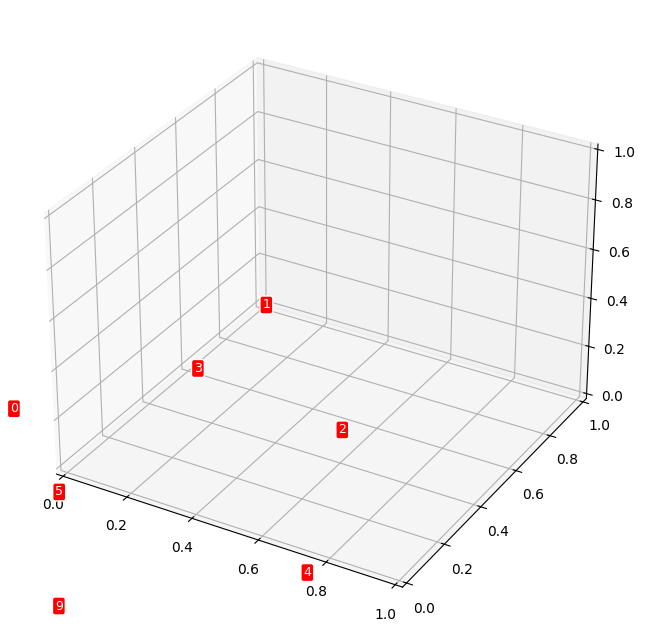

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Function to plot a quadratic Bezier curve (slight curve) with an arrow at the end
# Function to plot a quadratic Bezier curve (slight curve) with a scaled arrow at the end
def plot_curve_with_arrow(ax, p0, p1, p2, z_layer, link_color, show_arrow=False, arrow_scale=0.1, arrow_color = 'black'):
    t_vals = np.linspace(0, 1, 100)  # Parameter t values for interpolation
    curve_x = (1 - t_vals) ** 2 * p0[0] + 2 * (1 - t_vals) * t_vals * p1[0] + t_vals ** 2 * p2[0]
    curve_y = (1 - t_vals) ** 2 * p0[1] + 2 * (1 - t_vals) * t_vals * p1[1] + t_vals ** 2 * p2[1]
    curve_z = np.full_like(curve_x, z_layer)  # Keep z constant
    ax.plot(curve_x, curve_y, curve_z, color=link_color, alpha=0.8)

    if show_arrow:  # Add arrow to the last part of the curve
        # Define start and end points for the arrow
        arrow_start = np.array([curve_x[-2], curve_y[-2], curve_z[-2]])
        arrow_end = np.array([curve_x[-1], curve_y[-1], curve_z[-1]])
        
        # Ensure the arrow points in the correct direction
        direction = arrow_end - arrow_start
        if np.linalg.norm(direction) == 0:
            return  # Prevent division by zero if direction is zero

        direction = direction / np.linalg.norm(direction) * arrow_scale  # Scale the direction
        
        # Reverse the direction if needed (ensure the arrow points from p1 to p2)
        if (p2[0] < p1[0]) or (p2[1] < p1[1]):
            direction = -direction
        
        # Draw the arrow
        ax.quiver(arrow_start[0], arrow_start[1], arrow_start[2], 
                  direction[0], direction[1], direction[2], 
                  color=arrow_color, alpha=0.8, arrow_length_ratio=0.3)

# Updated plot_graph function to add node labels and arrows
def plot_graph(G, pos, color='blue', size=100, 
edgecolor='k', alpha=1, curvature=0.1, z=0, ax=None, 
nodes_color=None, nodes_shape=None,  
show_labels=False, labels = None, labels_color = 'white',
show_arrows=False,  arrow_scale=0.1, arrow_color = 'black'):

    if nodes_color is None:
        nodes_color = [color] * len(G.nodes())

    if nodes_shape is None:
        nodes_shape = ['o'] * len(G.nodes())

    if labels is None:
        labels = {node: str(node) for node in G.nodes()}  # Default label is the node number
    

    # Plot nodes

    for i, node in enumerate(G.nodes()):
        x, y = pos[node]       
        
        # Optionally show node labels
        if show_labels:
            # Add the label next to the node
            ax.text(x, y, z, labels[node], color=labels_color, fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor=color, edgecolor=labels_color, boxstyle='round,pad=0.2'))
        else:
            ax.scatter(x, y, z, color=nodes_color[i], marker=nodes_shape[i], s=size, edgecolor=edgecolor, alpha=alpha, zorder=2)


    # Plot edges with optional arrows
    for edge in G.edges():
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        p1 = np.array([x1, y1])
        p2 = np.array([x2, y2])
        control = control_point(p1, p2, curvature)  # Compute control point for curvature
        plot_curve_with_arrow(ax, p1, control, p2, z, color, show_arrow=show_arrows,  arrow_scale=arrow_scale, arrow_color = arrow_color)  # Draw curved edge with arrows



# Modify the multiplex plot function to accept show_arrows and show_labels arguments
def plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color=None, nodes_shape=None, 
intralayer_links_curvature=0.3, show_arrows=False, show_labels=False, labels = None,
arrow_scale  = 0.1, arrow_color = 'black'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(G)):
        plot_graph(G[i], layout, layers_colors[i], curvature=intralayer_links_curvature, z=layers_z_axis[i], 
                   nodes_color=nodes_color, nodes_shape=nodes_shape, ax=ax, show_arrows=show_arrows, 
                   show_labels=show_labels, arrow_scale=arrow_scale, arrow_color = arrow_color)
        
    inter_layer_links(G, layout, layers_z_axis, ax=ax)
    
    # Remove background, axis, and grid
    ax.set_axis_off()  # Turn off the axes
    ax.grid(False)  # Turn off the grid

    # Set viewing angle and plot
    ax.view_init(elev=20., azim=-60)  # Adjust view angle if needed
    plt.show()

# Example usage
# Parameters: n = number of nodes, k = each node is connected to k nearest neighbors in ring topology, p = rewiring probability
n = 10  # Number of nodes
k1, k2, k3 = 4, 3, 6  # Each node is connected to different neighbors in different layers
p1, p2, p3 = 0.3, 0.6, 0.2  # Rewiring probabilities
# Generate Watts-Strogatz graphs for each layer
G1 = nx.watts_strogatz_graph(n, k1, p1)
G2 = nx.watts_strogatz_graph(n, k2, p2)
G3 = nx.watts_strogatz_graph(n, k3, p3)
G = [G1, G2, G3]
layout = nx.spring_layout(G1, dim=2)
layers_z_axis = [0,3,6]
layers_colors = ['red', 'blue', 'green']
nodes_color = ['yellow', 'yellow',  'yellow', 'yellow', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
nodes_shape = ['o', 'o', 'o', 'o', '^', '^', '^', '^', '^', '^']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
plot_multiplex(G, layout, layers_z_axis, layers_colors,intralayer_links_curvature=0., show_arrows=False, labels=labels, show_labels=True, arrow_scale = 0.1)
plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color,nodes_shape, intralayer_links_curvature = 0, show_labels=False)

In [2]:
import plotly.graph_objects as go
import networkx as nx

def plot_multiplex_plotly(G, pos, layers_z_axis, layers_colors, labels=None):
    fig = go.Figure()

    if labels is None:
        labels = {node: str(node) for node in G.nodes()}  # Default label is the node number

    # Plot each layer
    for i, layer in enumerate(G):
        x, y = zip(*[pos[node] for node in layer.nodes()])
        z = [layers_z_axis[i]] * len(x)

        fig.add_trace(go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers+text',
            marker=dict(size=8, color=layers_colors[i]),
            text=[labels[node] for node in layer.nodes()],
            textposition='top center',  # Change if needed
            name=f'Layer {i+1}'
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        ),
        showlegend=True
    )

    fig.show()

# Example usage
plot_multiplex_plotly(G, pos, layers_z_axis, layers_colors, labels={i: f'Node {i}' for i in range(10)})


ModuleNotFoundError: No module named 'plotly'